In [682]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import numpy as np 
import json
from dataclasses import dataclass, field

In [683]:
Coordinates = tuple[int, int]

In [684]:
SET5_FOLDER_PATH = Path() / r"AI Training Sets-20231024T092556Z-001\AI Training Sets\Set5-1_WBC_Images" 
BASOS_FOLDER_PATH = Path()/ r"AI Training Sets-20231024T092556Z-001\AI Training Sets\Basos_Images"

In [685]:
with open(r"labels_basos_2023-11-01-11-49-24.json") as f:
    basos_anno_json = json.load(f)

In [686]:
basos_anno_json['B014_77I_T19095_RT_x40_z0_i02j07.jpg']['regions']['0']['shape_attributes']['all_points_x']

[252.85244035244025,
 274.632462132462,
 295.4224829224828,
 311.26249876249864,
 294.43248193248183,
 264.73245223245215,
 247.90243540243532,
 240.9724284724284,
 240.9724284724284,
 252.85244035244025]

In [687]:
@dataclass
class Cell:
    cell_class:str
    cell_location: np.ndarray

    def __post_init__(self):
        if self.cell_class not in set(['N', 'L', 'M','E','B']):
            raise ValueError("Cell needs to be of types -> 'N', 'L', 'M','E','B'") 

@dataclass
class ImageAnnotation:
    image_name: str
    file_path: str
    cells: list[Cell] = field(default=list)

    

In [688]:
neur = Cell(cell_class='N', cell_location=np.array([100, 200]))
bas = Cell(cell_class='B', cell_location=np.array([150, 250]))


In [689]:
im = ImageAnnotation(image_name="test.png", file_path='/test/')
im.cells = [neur]
im.cells.append(bas)
im

ImageAnnotation(image_name='test.png', file_path='/test/', cells=[Cell(cell_class='N', cell_location=array([100, 200])), Cell(cell_class='B', cell_location=array([150, 250]))])

In [690]:
def parse_annotations(annotantions_json:json, image_folder_path:str) -> list[ImageAnnotation]:
    """ Takes an json file with polygon annotations and returns a list of ImageAnnotation objects """
    
    annotations = []

    for file_name in annotantions_json:
        cells = []
        for region in annotantions_json[file_name]['regions']:
            shape_attributes = annotantions_json[file_name]['regions'][str(region)]['shape_attributes']
            region_attribute_label = annotantions_json[file_name]['regions'][str(region)]['region_attributes']['label']
            cell_loc = np.array([[x,y] for x,y in zip(shape_attributes['all_points_x'], shape_attributes['all_points_y'])])
            cell = Cell(cell_class=region_attribute_label, cell_location=cell_loc)
            cells.append(cell)
        image_annotation = ImageAnnotation(image_name=file_name, 
                                           file_path=(image_folder_path/file_name).as_posix(),
                                           cells=cells)
        annotations.append(image_annotation)            
            
    return annotations


In [691]:
# for file_name in basos_anno_json:
#     print(f"{file_name= }")
#     for region in basos_anno_json[file_name]['regions']:
#         _shape_attributes = basos_anno_json[file_name]['regions'][str(region)]['shape_attributes']
#         region_attribute_label = basos_anno_json[file_name]['regions'][str(region)]['region_attributes']['label']
#         print(f'{region_attribute_label = }')
#         print(f"{_shape_attributes['all_points_x'] = }")
#         print(f"{_shape_attributes['all_points_y'] = }")
#         print()
#         # annotation = ImageAnnotation(image_name=file_name, file_path=(BASOS_FOLDER_PATH/file_name).as_posix())

In [692]:
annotations_list = parse_annotations(annotantions_json=basos_anno_json, image_folder_path=BASOS_FOLDER_PATH)

In [693]:
annotations_list

[ImageAnnotation(image_name='B014_77I_T19095_RT_x40_z0_i02j07.jpg', file_path='AI Training Sets-20231024T092556Z-001/AI Training Sets/Basos_Images/B014_77I_T19095_RT_x40_z0_i02j07.jpg', cells=[Cell(cell_class='N', cell_location=array([[252.85244035,  14.85001485],
        [274.63246213,  11.88001188],
        [295.42248292,  15.84001584],
        [311.26249876,  33.66003366],
        [294.43248193,  63.36006336],
        [264.73245223,  69.3000693 ],
        [247.9024354 ,  58.41005841],
        [240.97242847,  44.55004455],
        [240.97242847,  25.74002574],
        [252.85244035,  14.85001485]])), Cell(cell_class='B', cell_location=array([[ 999.31318681,  482.13048213],
        [ 977.53316503,  472.23047223],
        [ 952.78314028,  484.11048411],
        [ 943.87313137,  503.91050391],
        [ 942.88313038,  531.63053163],
        [ 958.72314622,  543.51054351],
        [ 979.51316701,  548.46054846],
        [ 986.44317394,  539.55053955],
        [1000.        ,  536.5805365

In [694]:
def validate_file_path(file_path:str|Path) -> str:
    """ Checks to see if the file path is valid """
    if not isinstance(file_path, (str, Path)):
        raise ValueError(f"{file_path} must be a str or Path object")
    if isinstance(file_path, str):
        file_path = Path(file_path)
    if not file_path.is_file():
        raise FileNotFoundError(f"Cannot find this file -> {file_path} ")
    return file_path.as_posix()


def get_image_from_path(file_path:str | Path) -> np.ndarray:
    """ Takes an file path and returns an image as array """
    file_path = validate_file_path(file_path= file_path)
    img = cv2.imread(filename=file_path) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [695]:
def draw_image_annotation(annotation:ImageAnnotation) -> None:
    _, ax = plt.subplots(figsize=(5,5))
    ax.set_title(annotation.image_name, fontsize=8)
    img = get_image_from_path(file_path=annotation.file_path)
    
    cell =  annotation.cells[0]
    poly_points = cell.cell_location
    # poly_points = poly_points.reshape((-1,1,2))

    test_anno = annotations_list[0].cells[0].cell_location.astype(np.int32)
    # test_anno.reshape((-1,1,2))

    img = cv2.polylines(img, [test_anno], isClosed=True, color=(255,0,0), thickness=2)
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.show()
    

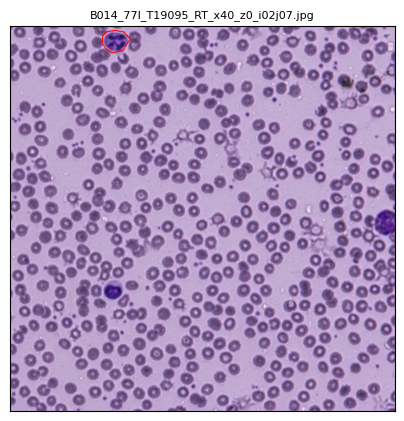

In [696]:
draw_image_annotation(annotations_list[0])

In [713]:
test_anno = annotations_list[0].cells[0].cell_location.astype(np.int32)
test_anno

array([[252,  14],
       [274,  11],
       [295,  15],
       [311,  33],
       [294,  63],
       [264,  69],
       [247,  58],
       [240,  44],
       [240,  25],
       [252,  14]])

In [698]:
img = get_image_from_path(BASOS_FOLDER_PATH/annotations_list[0].image_name)

In [709]:
mask = np.zeros_like(img)
mask = cv2.fillPoly(mask, [test_anno], (255,255,255))

In [700]:
mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
mask_gray.shape

(1000, 1000)

In [712]:
nonzero_coords = cv2.findNonZero(mask_gray)

# Calculate the shape properties
x, y, width, height = cv2.boundingRect(nonzero_coords)
# area = cv2.contourArea(nonzero_coords)
# perimeter = cv2.arcLength(nonzero_coords, closed=True)


In [702]:
x, y, width, height

(240, 11, 72, 59)

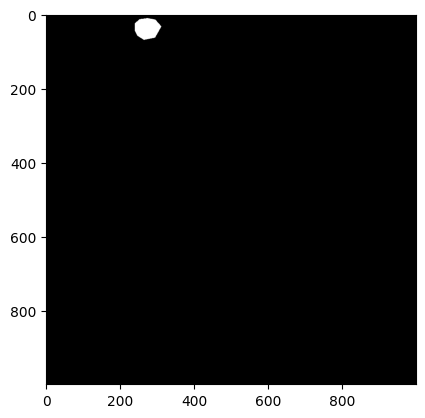

In [710]:
plt.imshow(mask)
plt.show()

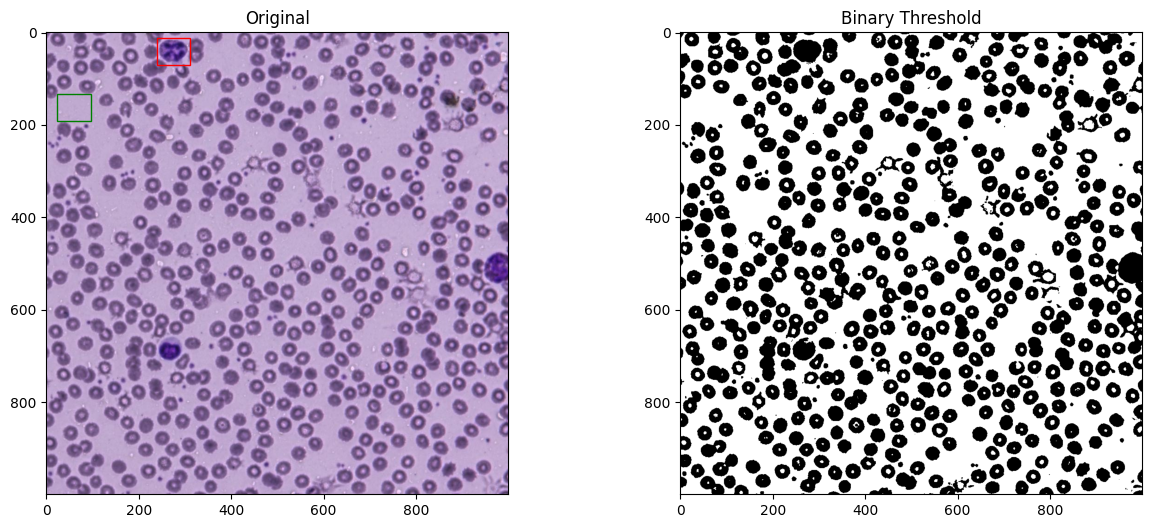

In [704]:
import matplotlib.patches as patches


gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

ret, binary = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

ax[0].set_title("Original")
ax[0].imshow(img)
ax[0].add_patch(patches.Rectangle(xy=(x,y), width=width, height=height, linewidth=1, edgecolor='r', facecolor='none'))
ax[0].add_patch(patches.Rectangle(xy=(24,133), width=width, height=height, linewidth=1, edgecolor='green', facecolor='none'))

# ax[1].set_title("Gray Image")
# ax[1].imshow(gray_img, cmap='grey')

ax[1].set_title("Binary Threshold")
ax[1].imshow(binary, cmap='grey')


plt.show()

In [737]:
image_height, image_width = binary.shape
image_height, image_width, width, height

(1000, 1000, 72, 59)

In [ ]:
for y_ in range(0, image_height - height + 1):
    for x_ in range(0, image_width - width + 1):
        # Extract the region of interest (ROI) using the window size
        roi_ = binary[y_:y_ + height, x_:x_ + width]
        if not 0 in roi_:
            print(x_, y_ )


In [743]:
# def copy_paste_cell(img:np.ndarray, )

copied_region = cv2.bitwise_and(img, mask)

In [1070]:
copied_region.shape

(1000, 1000, 3)

In [753]:
test_anno

array([[252,  14],
       [274,  11],
       [295,  15],
       [311,  33],
       [294,  63],
       [264,  69],
       [247,  58],
       [240,  44],
       [240,  25],
       [252,  14]])

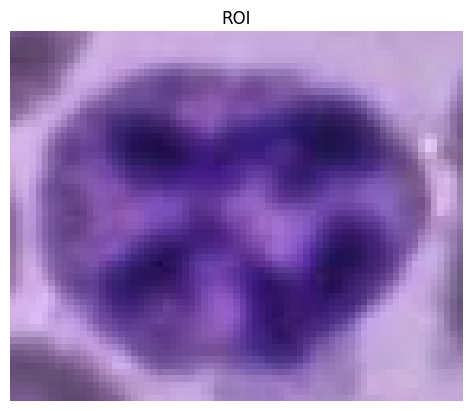

In [758]:
roi = img[np.min(test_anno[:,1]) : np.max(test_anno[:,1]), np.min(test_anno[:,0]) : np.max(test_anno[:,0])]
plt.imshow(roi)
plt.axis('off')
plt.title('ROI')
plt.show()

In [760]:
roi.shape, width, height

((58, 71, 3), 72, 59)

In [782]:

src1_mask = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
src1_mask.fill(0)
mask_inv = cv2.bitwise_not(src1_mask)
mask2 = src1_mask[np.min(test_anno[:,1]):np.max(test_anno[:,1]),np.min(test_anno[:,0]):np.max(test_anno[:,0])]


img1_bg = cv2.bitwise_and(roi,mask_inv)

# m2 = src1_mask[np.min(poly[:,1]):np.max(poly[:,1]),np.min(poly[:,0]):np.max(poly[:,0])]

# img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)

plt.imshow(mask2, cmap='gray')
plt.show()



error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\core\src\arithm.cpp:214: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and type), nor 'array op scalar', nor 'scalar op array' in function 'cv::binary_op'


In [739]:
copied_height, copied_width, _ = copied_region.shape
copied_height, copied_width

(1000, 1000)

In [740]:
destination_x, destination_y = 24,133

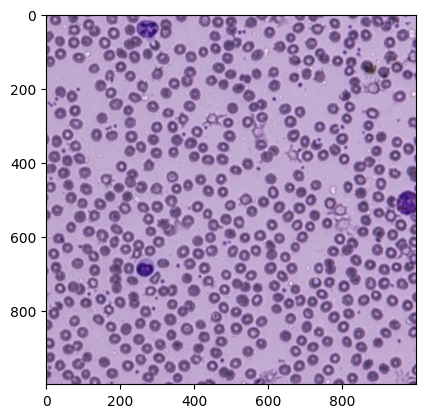

In [761]:
new_region = img.copy()
plt.imshow(new_region)
plt.show()

In [1194]:
mat = np.zeros((10,10,3), dtype=np.int32)
mat[0,5,:] = [255,0,0]
mat[1,4:7,:] = [255,25,255]
mat[2,5,:] = [255,0,0]

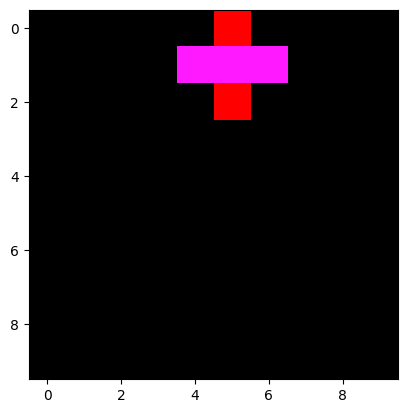

In [1195]:
plt.imshow(mat)
plt.show()

In [1196]:
non_zero_mask = np.any(mat!=[0,0,0], axis=2)
gray_mask = non_zero_mask * 255

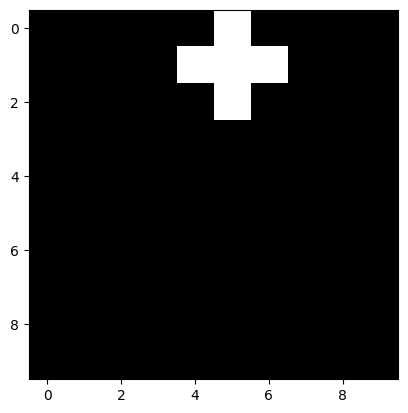

In [1197]:
plt.imshow(gray_mask, cmap='gray')
plt.show()

In [1198]:
img_indices = np.where(gray_mask!=0)
img_indices

(array([0, 1, 1, 1, 2], dtype=int64), array([5, 4, 5, 6, 5], dtype=int64))

In [1199]:
roi_box = mat[np.min(img_indices[0]) : np.max(img_indices[0] + 1), np.min(img_indices[1]) : np.max(img_indices[1] + 1)] 

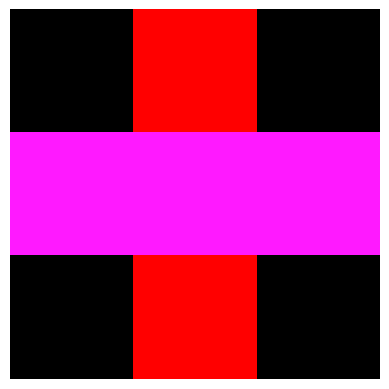

In [1200]:
plt.imshow(roi_box)
plt.axis('off')
plt.show()

In [1201]:
non_zero_mask_box = np.any(roi_box!=[0,0,0], axis=2)
gray_mask_box = non_zero_mask_box * 255

In [1202]:
# 0 -> black, 255-> white
np.all(mat[0:3,0:3] == np.zeros_like(mat[0:3,0:3]))


True

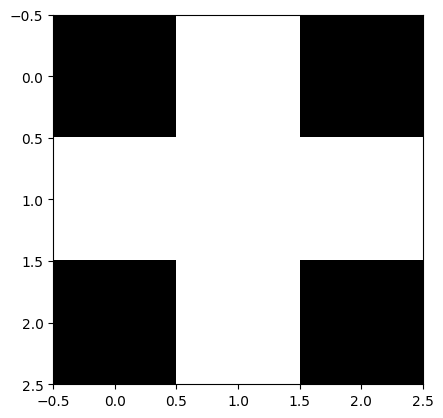

In [1203]:
plt.imshow(gray_mask_box, cmap='gray')
plt.show()

In [1204]:
shape_indices = np.where(gray_mask_box!=0) 
shape_indices

(array([0, 1, 1, 1, 2], dtype=int64), array([1, 0, 1, 2, 1], dtype=int64))

In [1205]:
row_start, row_end = np.min(img_indices[0]) , np.max(img_indices[0] + 1)
col_start, col_end = np.min(img_indices[1]) , np.max(img_indices[1] + 1)

row_offset, col_offset = row_end-row_start, col_end-col_start

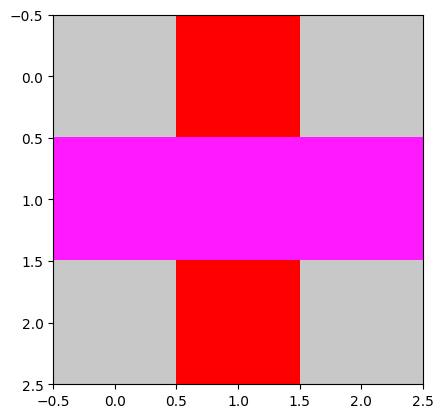

In [1206]:
new_box = np.ones_like(roi_box) * 200
new_box[shape_indices[0], shape_indices[1]] = roi_box[shape_indices[0], shape_indices[1]]
plt.imshow(new_box)
plt.show()

In [1207]:
for row_i in range(mat.shape[0] - row_offset + 1):
    for col_i in range(mat.shape[1] - col_offset + 1):
        box = mat[row_i:row_i+row_offset, col_i:col_i+col_offset]
        if np.all(box == np.zeros_like(box)):
            box[shape_indices[0], shape_indices[1]] = roi_box[shape_indices[0], shape_indices[1]]

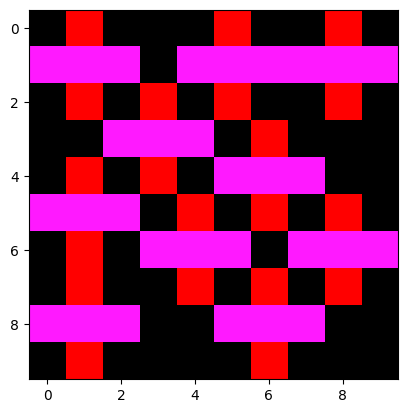

In [1208]:
plt.imshow(mat)
plt.show()

#012 Blending and Pasting Images Using OpenCV<br>
https://datahacker.rs/012-blending-and-pasting-images-using-opencv/

In [1209]:
# https://datahacker.rs/012-blending-and-pasting-images-using-opencv/

In [1210]:
tt.shape

(867, 976, 3)

In [1211]:
arr = np.array([[1, 2, 3],
                [4, 5, 6],
                [7, 8, 9]])

# Iterate over 3 rows and 3 columns at once using nested loops
for i in range(3):
    for j in range(3):
        value = arr[i, j]
        print(value)

1
2
3
4
5
6
7
8
9
